In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/snehshah0629/tweet_airline_sentiment_analysis/master/tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df = df[['airline_sentiment', 'text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
sentiment_counts = df.groupby(['airline_sentiment']).count()

In [6]:
sentiment_counts.index.to_numpy()

array(['negative', 'neutral', 'positive'], dtype=object)

In [7]:
sentiment_counts['text'].to_numpy()

array([9178, 3099, 2363])

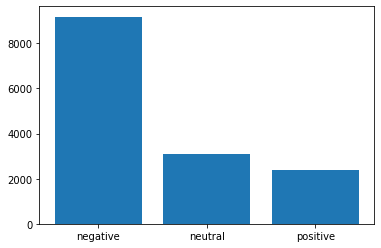

In [8]:
plt.bar(sentiment_counts.index.to_numpy(), sentiment_counts['text'].to_numpy())
plt.xlabel
plt.show()

In [9]:
df['text'] = df['text'].str.lower()
df.head()

,airline_sentiment,text
0,neutral,@virginamerica what @dhepburn said.
1,positive,@virginamerica plus you've added commercials t...
2,neutral,@virginamerica i didn't today... must mean i n...
3,negative,@virginamerica it's really aggressive to blast...
4,negative,@virginamerica and it's a really big bad thing...


In [10]:
df['text'] = df['text'].str.replace('[^a-zA-z0-9\s]', '')
df.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus youve added commercials to ...
2,neutral,virginamerica i didnt today must mean i need t...
3,negative,virginamerica its really aggressive to blast o...
4,negative,virginamerica and its a really big bad thing a...


In [11]:
tweets = df['text'].values

tokenizer = Tokenizer(num_words = 5000, split = " ")
tokenizer.fit_on_texts(tweets)

X = tokenizer.texts_to_sequences(tweets)
X = pad_sequences(X)
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   78,   57,  218],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   78,  540,  541, 1122, 2459,    1,    2,  197],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   78,
           3,  185,   98,  775,  565,    3,   75,    1,  148,  143,  191],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   78,   64,  132, 3670,    1, 4604,
        4605,  981,   15,   21, 3098, 3671,   61,   54,   22,  488, 2723],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [12]:
model = Sequential()
model.add(Embedding(5000, 256, input_length = X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.2))
model.add(Dense(3, activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 33, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,806,083
Trainable params: 1,806,083
Non-trainable params: 0
_________________________________________________________________


In [13]:
y = pd.get_dummies(df['airline_sentiment']).values

In [14]:
X.shape

(14640, 33)

In [15]:
y.shape

(14640, 3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [17]:
batch_size = 16
epochs = 4

model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/4
641/641 [==============================] - 192s 262ms/step - loss: 0.7526 - accuracy: 0.6932
Epoch 2/4
641/641 [==============================] - 167s 261ms/step - loss: 0.4285 - accuracy: 0.8342
Epoch 3/4
641/641 [==============================] - 167s 261ms/step - loss: 0.3208 - accuracy: 0.8781
Epoch 4/4
641/641 [==============================] - 167s 260ms/step - loss: 0.2421 - accuracy: 0.9080


In [18]:
preds = model.predict(X_test)

correct_by_sentiment = np.zeros(3)
pred_by_sentiment = np.zeros(3)
real_by_sentiment = np.zeros(3)

correct = 0
for i, pred in enumerate(preds):
  if np.argmax(pred) == np.argmax(y_test[i]):
    correct += 1
    correct_by_sentiment[np.argmax(pred)] += 1
  pred_by_sentiment[np.argmax(pred)] += 1
  real_by_sentiment[np.argmax(y_test[i])] += 1

In [19]:
precision = correct_by_sentiment / pred_by_sentiment
precision

array([0.82858079, 0.66424419, 0.75344564])

In [20]:
recall = correct_by_sentiment / real_by_sentiment
recall

array([0.92668622, 0.50553097, 0.64736842])

In [21]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

array([0.87489185, 0.5741206 , 0.69639066])